# Modèles d'apprentissage

On explore dans ce notebook plusieurs modèles d'apprentissage pour réaliser des prédictions sur la consommation d'énergie et les emissions de GES dans les bâtiments non-résidentiels de la ville de Seattle. Les prédictions reposent sur les jeux de données des années 2015 et 2016. 

On compare les prédictions obtenues grâce aux modèles suivants:
- régression linéaire, qui constitue la "baseline"
- régression polynomiale, réalisée en appliquant une tranformation PolynomialeFeatures pour modéliser de potentielles interactions entre les prédicteurs et Lasso pour réduire la complexité du modèle obtenu
- k-NN pour lever toute hypothèse de modélisation sur la dépendance des cibles aux prédicteurs
- RandomForest pour exloiter la puissance des méthodes ensemblistes

On commence par charger deux ensembles de jeux de données (4 au total, deux pour chaque cible), obtenus après sélection des variables pertinentes, nettoyage et feature engineering.

On évalue la performance de chaque modèle sur chaque jeu, et on compare les performances obtenues pour chaque modèle pour décider du meilleur modèle pour ce problème.

__[III Modèles](#III-Modèles)__\
[III.1 Chargement et préparation du jeu de données](#III.1-Chargement-et-préparation-du-jeu-de-données)\
[III.2 Baseline: Régression linéaire simple](#III.2-Baseline:-Régression-linéaire-simple)\
[III.3 kNN](#III.3-kNN)\
[III.4 Régression polynomiale et sélection de prédicteurs avec Lasso](#III.4-Régression-polynomiale-et-sélection-de-prédicteurs-avec-Lasso)\
[III.5 RandomForestRegressor](#III.5-RandomForestRegressor)\
__[IV Choix du modèle](#IV-Choix-du-modèle)__\
__[V ENERGYSTARScore](#V-ENERGYSTARScore)__\
__[VI Prédiction de TotalGHGEmission](#VI-Prédiction-de-TotalGHGEmissions)__

In [306]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# III Modèles
## III.1 Chargement et préparation du jeu de données

Importation des modules nécessaires

In [307]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline, make_pipeline
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn import set_config

set_config(display='diagram')

Chargement des jeux de données nettoyés et préparés pour l'apprentissage

In [308]:
SEUmodel2 = pd.read_csv("./SEUmodel2.csv")
GHGmodel2 = pd.read_csv("./GHGmodel2.csv")

SEUmodel3 = pd.read_csv("./SEUmodel3.csv")
GHGmodel3 = pd.read_csv("./GHGmodel3.csv")

On définit les listes PCA_COLS, TARGET_COLS, ENERGY_COLS et quelques fonctions qui nous seront utiles lors des traitements.

In [309]:
SEUmodel2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1846 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1846 non-null   object 
 1   PrimaryPropertyType              1846 non-null   object 
 2   YearBuilt                        1846 non-null   object 
 3   NumberofBuildings                1846 non-null   float64
 4   NumberofFloors                   1846 non-null   float64
 5   PropertyGFATotal                 1846 non-null   int64  
 6   PropertyGFAParking               1846 non-null   int64  
 7   PropertyGFABuilding(s)           1846 non-null   int64  
 8   LargestPropertyUseType           1846 non-null   object 
 9   LargestPropertyUseTypeGFA        1846 non-null   float64
 10  SecondLargestPropertyUseType     1846 non-null   object 
 11  SecondLargestPropertyUseTypeGFA  1846 non-null   float64
 12  ThirdLargestProperty

In [91]:
# columns to which PCA is applied
PCA_COLS = ["PropertyGFATotal", 
            "PropertyGFAParking",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "SecondLargestPropertyUseTypeGFA",
            "ThirdLargestPropertyUseTypeGFA"]

# target variables, or variables that may cause data leakage
TARGET_COLS = ["SiteEnergyUse",
               "SiteEnergyUse_log",
               "TotalGHGEmissions", 
               "TotalGHGEmissions_log"]

# variables related to energy (type, source) used in the buildings
ENERGY_COLS = ["Electricity(kBtu)",
               "NaturalGas(kBtu)",
               "SteamUse(kBtu)",
               "OtherFuelUse(kBtu)",
               "ENERGYSTARScore",
               "NaturalGas_ratio",
               "Steam_ratio",
               "OtherFuel_ratio"]

def preprocessing(X):
    """Fonction qui prend en entrée le jeu de données uniquement constitué des prédicteurs, et 
    renvoie le pipeline de prétraitement.
    
    Fonction qui prend en entrée le dataframe constitué des prédicteurs uniquement, et qui renvoie le pipeline
    constitué des deux instances de ColumnTransformers:
    - preprocessor1 réalise la standardisation des variables quantitatives, un encodage one-hot sur les variables
    catégorielles, et calcule 4 nouvelles variables obtenues par ACP sur les 6 variables PCA_COLS
    - preprocessor2 retire du nouveau jeu de données les 6 colonnes ayant servi à réaliser l'ACP
    
    Parameters
    ----------
    X : pd.DataFrame
        Features used to make predictions on target
    
    Returns
    -------
    sklearn.pipeline.Pipeline
        Preprocessing pipeline.
    """
    
    # One-hot encoding of categorical variable
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
    # Standard scaling of numerical features
    numeric_transformer = StandardScaler()  
            
    std_pca_transformer = make_pipeline(StandardScaler(),
                                        PCA(n_components=4))  
    
    # Récupération des indices correspondant aux variables sur lesquelles on réalise l'ACP dans le tableau
    # numpy créé après preprocessing1. Le tableau numpy est en effet réorganisé lors du preprocessing avec les
    # colonnes numeriques d'abord, puis les colonnes créées lors de l'ACP et enfin les colonnes catégorielles
    X_only_numeric = X.select_dtypes(include=['float64'])
    pca_index = [X_only_numeric.columns.get_loc(c) for c in PCA_COLS]
    
      
    preprocessor1 = ColumnTransformer(transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('std_pca', std_pca_transformer, PCA_COLS),
        ('cat', categorical_transformer, selector(dtype_include="category"))],
                                      remainder='passthrough')
    
    preprocessor2 = ColumnTransformer(transformers=[('drop_pca', 'drop', pca_index)], 
                                      remainder='passthrough'
                                     )
    preprocessor = Pipeline(steps=[('preprocessor1', preprocessor1),
                                   ('preprocessor2', preprocessor2),
                                   ('pass', 'passthrough')])
    
    return preprocessor

#def make_crossvalreport(cv):
#    
#    cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
#    moyenne = pd.DataFrame(data=cv_results.to_numpy().mean(axis=0).reshape(1, -1), 
#                           columns=cv_results.columns, 
#                           index=["moyenne"])
    
#    cvresults = pd.concat([cv_results, moyenne])
    
#    return cvresults



def modelpreparation(model, targets=TARGET_COLS, energy_cols=ENERGY_COLS):
    """Fonction qui convertit les variables issues du jeu de données aux types 
    quantitatif et catégoriel. 
    
    Le formattage est assuré en convertissant toutes les variables quantitatives 
    en 'float64' et toutes les variables catégorielles en 'category', puis renvoie un nouveau dataframe des 
    variables converties. Renvoie également la liste des prédicteurs.
    
    Parameters
    ----------
    model : pd.DataFrame
            Data (features and target)
            
    targets : list, default=TARGET_COLS
            Target(s) or variables which may cause data leakage. If no list is passed, defaults to TARGET_COLS
            
    energy_cols : list, default=ENERGY_COLS
            variables related to energy (type, source) used in the buildings. Includes 'ENERGYSTARScore'.
            If no list is passed, defaults to ENERGY_COLS.
            
    Returns
    -------
    md : pd.DataFrame
        DataFrame with variables cast to types 'float64' or 'category'
        
    features : list
        Features
        
        """
    
    md = model.copy()

    # Sélection des prédicteurs
    features = [col for col in md.columns if (col not in targets) and (col not in energy_cols)]

    # Séparation des variables en types "category" et "float64"
    # On change le type des variables numériques non catégorielles en float64
    cols_to_transform = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)"]
    md[cols_to_transform] = md[cols_to_transform].astype("float64")

    # Les variables int64 et object sont passées en type 'category'
    cat_cols = md.dtypes[(md.dtypes=="int64") | (md.dtypes=="object")].index
    md[cat_cols] = md[cat_cols].astype("category")
    
    return md, features

def create_pipeline(model, X, regressor=False):
    """Création du pipeline incluant l'étape de prétraitement des données et une étape de prédiction.
    
    Parameters
    ----------
    model : Estimator implementing 'fit'
            The object to use to fit the data.
            
    X : pd.DataFrame
        Features.
        
    regressor : bool, par défaut: False 
        Whether or not a regression step should be included in the pipeline.
    
    Returns
    -------
    reg : sklearn.pipeline.Pipeline
        Complete (preprocessing and regression) pipeline
        
        """
    
    preprocessor = preprocessing(X)
    
    if not regressor:
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                          #('pass', 'passthrough')
                         ])
    else:
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model)
                             ])
    return reg


def crossval_noGS(target, features, df, model):
    """Renvoie les résultats de validation croisée de la prediction de target à partir des features 
    ainsi que le pipeline de prétraitement et régession utilisé.
   
    Paramètres
    ----------
    target : str
       target variable - variable to predict
       
    features : str ou liste de str
        Variables used to make the predictions on target.
        
    df : pandas.DataFrame
        the data - features and target
    
    model : Estimator implementing 'fit'
        The object to use to fit the data.
        
    Returns
    -------
    cv : pandas.DataFrame
        Cross-validation results from cross_validate method, sorted by descending order of 'test_score'
        
    reg : sklearn.pipeline.Pipeline
        Fitted preprocessing and regression pipeline.
        
        """
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    
    # Pipeline de prétraitement et de régression
    reg = create_pipeline(model, X, regressor=True)
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    cv = cross_validate(reg, X, y, cv=kf,
                            scoring=('r2'),
                            return_train_score=True)
    
    cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
    
    if reg:
        return cv_results, reg
    else:
        return cv_results

def crossval_GS(target, features, df, params, model, score):
    """Réalise une optimisation sur grille (GridSearch) du(des) meilleur(s) hyperparamètres pour le
    modèle model_gs. Renvoie l'objet sklearn.model_selection.GridSearchCV contenant les données issues de
    l'optimisation. Affiche les résultats de l'optimisation: meilleur(s) hyperparamètre(s), scores sur les jeux
    d'entraînement et de test.
    
    Parameters
    ----------
    target : str
       target variable - variable to predict
       
    features : str or list
        Variables used to make the predictions on target.
        
    df : pandas.DataFrame
        the data - features and target
    
    model : Estimator implementing 'fit'
        The object to use to fit the data.
    
    score : str or tuple
        Metric(s) used to evaluate the predictions
        
    Returns
    -------
    regr : sklearn.model_selection.GridSearchCV
        Fitted GridSearchCV object
    
    """
    
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = df[features]
    y = df[target]
    
    reg = create_pipeline(model, X, regressor=True)

    # Nested cross-validation pour la validation du (des) hyperparamètre(s) par GridSearch
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre(s) à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Régression avec sélection d'(des)hyperparamètre(s) par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Séparation entraînement-test. Le jeu X_train est lui-même séparé en jeu d'entraînement et de validation
    # lors de la recherche sur grille.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=0)
    
    # Optimisation de l'estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("\nMeilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance sur le jeu d'entraînement
    print("\nPerformance sur le jeu d'entraînement' : {:.3f}".format(regr.score(X_train, y_train)))
    
    # Performance en généralisation du meilleur modèle sur le jeu de test
    y_pred = regr.predict(X_test)
    print("Performance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return regr

def print_cvresults(score, regr, param_grid):
    """Takes as input a GridSearchCV object and prints various results.
    
    Prints mean train and test scores for the best estimator returned by GridSearchCV
    
    Parameters
    ----------
    score : str or tuple
        Metric(s) used to evaluate the predictions
    
    regr : sklearn.model_selection.GridSearchCV
        Fitted GridSearchCV object
        
    param_grid : dict
        Dictionary of the various hyperparameters to evaluate.
        
        The dictionary must be formatted as {'name':value}, where 'name'
        is of the form "regressor__"+key, with key being the name of the hyperparameter
        as given in the estimator's signature.
        
    Returns
    -------
    cv_results : pandas.DataFrame
        GridSearchCV cross-validation results
        
    """
    # Résultats de la validation croisée
    cv_results = pd.DataFrame(regr.cv_results_).sort_values("mean_test_r2", ascending=False)
    
    for f in ('train', 'test'):
        cv_results[f'mean_{f}_neg_root_mean_squared_error'] *= -1
        
    print("\nScores moyens sur le jeu d'entraînement, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_train_r2"],
                                         cv_results.iloc[0]["std_train_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_train_neg_root_mean_squared_error"],
                                           cv_results.iloc[0]["std_train_neg_root_mean_squared_error"]))
    print('')
    print("\nScores moyens sur le jeu de validation, avec le meilleur modèle:")
    print("R2: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_test_r2"], cv_results.iloc[0]["std_test_r2"]))
    print("RMSE: {:.3f} +/- {:.3f}".format(cv_results.iloc[0]["mean_test_neg_root_mean_squared_error"], cv_results.iloc[0]["std_test_neg_root_mean_squared_error"]))
    
    return cv_results

def plot_traintestscores(cv_results, score, axis_scale="log", plot_param=["alpha"], savefig=False, figname='untitled'):
    """Plots GridSearchCV results.
    
    Draw a plot (one plot per hyperparameter) of mean_train and mean_test scores/errors 
    for each hyperparameter being optimised.
    
    Parameters
    ----------
    cv_results : pandas.DataFrame
        GridSearchCV cross-validation results
    
    score : str or tuple
        Metric(s) used to evaluate the predictions
        
    axis_scale : str, default="log"
        Type of scale to use to draw the plot. Basically 'linear' or 'log' depending on the hyperparameter
    
    plot_param : list, default=["alpha"]
        Hyperparameter against which to plot cross-validated results
        
    savefig : bool, default=False
        Whether or not to save the plot to a .png file.
        
    figname : str, default='untitled'
        Name to give the file if savefig is True.
        
        
    """
    fig = plt.figure(figsize=(5*len(plot_param), 4))
    
    # Affiche les scores obtenus sur les jeux d'entrainement et de test
    for i, pp in enumerate(plot_param):
        d = cv_results.set_index("param_regressor__{}".format(pp))
        cols = []
        for t in ("train", "test"):
            for s in score: 
                cols.append("mean_{}_{}".format(t, s))
        
        if None in d.index:
            d.rename(index={None: 'None'})
        
        ax = fig.add_subplot(1, len(plot_param), i+1)
        sns.lineplot(data=d[cols], ax=ax)
        ax.set_xscale(axis_scale)
        ax.set_xlabel(pp, size=12)
        ax.legend(loc='best', frameon=False, fontsize='small')
        
        # We change the fontsize of minor ticks label 
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        
    if savefig:
        plt.savefig(f'./{figname}', dpi=300)
        
    plt.tight_layout()



## III.2 Baseline: Régression linéaire simple

On commence donc par effectuer une première prédiction à l'aide du modèle de régression linéaire. On utilise les jeux de données SEUmodel2 et GHGmodel2 qui contiennent toutes les variables à l'exception de DataYear, et donc les modalités pour YearBuilt on été groupées en deux groupes: before_1980 et after_1980. On réalise une validation croisée simple 5-folds pour se donner une idée de la performance moyenne de ce modèle.

In [74]:
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}
for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    model = LinearRegression()
    cv, reg = crossval_noGS(target, features, m1, model, reg=True)    
    print("\nRésultat pour la cible {}:".format(target_name))
    print(cv)
    print('')
    print("Score d'entraînement : {:.3f} +/- {:.3f}".format(cv['train_score'].mean(), cv['train_score'].std()))
    print("Score de test : {:.3f} +/- {:.3f}".format(cv['test_score'].mean(), cv['test_score'].std()))
    print("="*80)


Résultat pour la cible SiteEnergyUse:
   fit_time  score_time  test_score  train_score
1  0.064139    0.016020    0.611665     0.575845
4  0.063942    0.015277    0.588713     0.582092
0  0.114493    0.016676    0.576113     0.584551
3  0.069028    0.015342    0.519275     0.596619
2  0.062573    0.015799    0.518558     0.590573

Score d'entraînement : 0.586 +/- 0.008
Score de test : 0.563 +/- 0.042

Résultat pour la cible TotalGHGEmissions:
   fit_time  score_time  test_score  train_score
4  0.072329    0.021662    0.682265     0.636555
0  0.082473    0.019352    0.658107     0.640956
1  0.098897    0.023105    0.628060     0.643672
3  0.057012    0.015571    0.600963     0.656025
2  0.062445    0.015088    0.566182     0.661834

Score d'entraînement : 0.648 +/- 0.011
Score de test : 0.627 +/- 0.046


Les scores indiquent clairement une performance meilleure qu'une estimation basée uniquement sur la valeur moyenne des cibles. Néanmoins, les scores sur les jeux d'entraînement indiquent un possible sous-apprentissage. Par ailleurs, un des avantages de LinearRegression est que l'on peut afficher l'importance relative des variables grâce aux coefficients de la régression, où en principe plus un coefficient est élevé, plus la variable associée est importante.


Résultat pour la cible SiteEnergyUse:


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


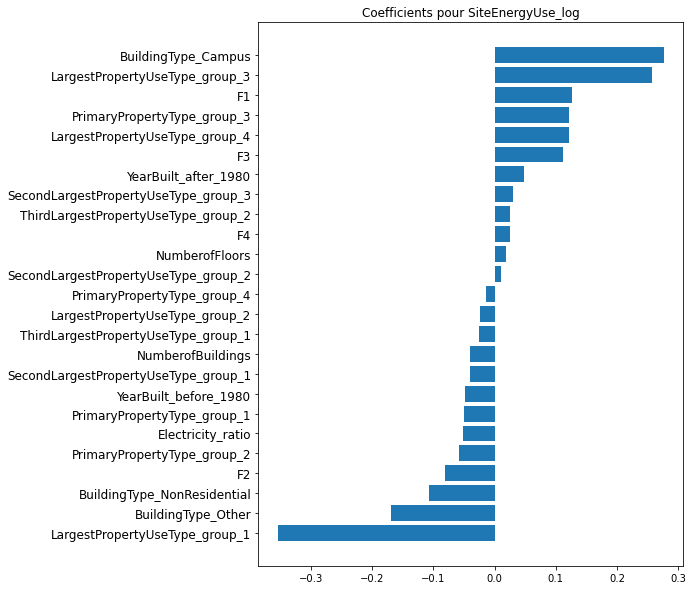


Résultat pour la cible TotalGHGEmissions:


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


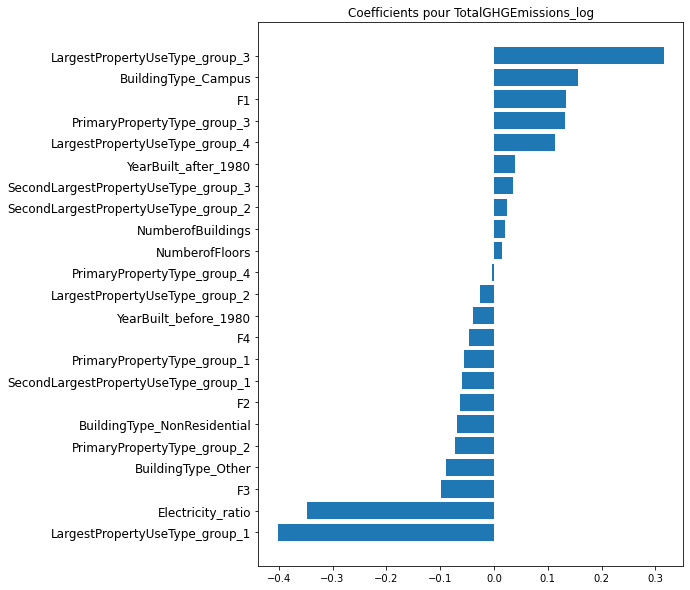

In [10]:
for target, m in models.items():
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    X = m1[features]
    y = m1[target]
    model = LinearRegression()
    reg = create_pipeline(model, X, regressor='True')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    reg.fit(X_train, y_train)
    print("\nRésultat pour la cible {}:".format(target_name))
    
    # Reconstitution des noms de variables obtenues après transformation du dataset
    num_cols = ['NumberofBuildings', 'NumberofFloors', 'Electricity_ratio', 'F1',
            'F2', 'F3', 'F4']
    
    cat_cols = X.dtypes[X.dtypes=='category'].index
    
    dummies = []
    for c in cat_cols:
        for m in np.sort(X[c].unique()):
            dummies.append(c+"_{}".format(m))
        
    transformed_features = list(np.concatenate((num_cols, dummies)))
    
    # Récupération des coefficients de la régression
    data = reg.named_steps['regressor'].coef_
    
    # Affichage des résultats
    d = pd.Series(data=data, index=transformed_features).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(d.index, d)
    ax.invert_yaxis()
    ax.set_title(f"Coefficients pour {target}")
    ax.set_yticklabels(d.index, size=12)
    plt.subplots_adjust(left=0.4, right=0.99)
    plt.savefig('./lregcoefs', dpi=300)
    plt.show()
    

Dans les deux cas, les variables les plus importantes sont BuildingType, LargestPropertyUseType, PrimaryPropertyType ainsi que les première et troisième variables issues de l'ACP. La première variables (F1) est essentiellement une combinaison des variables PropertyGFATotal, LargestPropertyUseTypeGFA, PropertyGFABuilding(s), c'est-à-dire les variables associées avec la surface totale ou la surface totale utilisée pour l'usage principal du bâtiment en question. La troisième variable (F3) est elle principalement associée avec la surface du parking.

## III.3 Régression polynomiale et sélection de prédicteurs avec Lasso

On souhaite formuler un modèle capable d'apprendre plus du jeu données. On se tourne vers la généralisation de LinearRegression qui consiste à ajouter les intéractions entre les prédicteurs. On va donc utiliser la classe PolynomialFeatures pour réaliser cela, et on combinera avec l'estimateur Lasso de manière à réduire la complexité du modèle obtenu. En effet, même en se restraignant à un ordre 2, la prise en compte des interactions génère un nombre important de nouvelles variables. A cause du petit nombre d'individus dans le jeu de données, il y a un risque de surapprentissage si aucune régularisation n'est mise en place. 

Pour éviter tout problème de surapprentissage, on utilise outre Lasso les jeux de données SEUmodel3 et GHGmodel3 dans lesquels on n'a gardé que les 4 variables catégorielles les plus fortement corrélées aux cibles d'après l'ANOVA réalisée lors de l'analyse exploratoire.


Résultat pour la cible SiteEnergyUse:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.0017433288221999873}

Performance sur le jeu d'entraînement' : 0.685
Performance en généralisation sur le jeu de test : 0.638


Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.690 +/- 0.005
RMSE: 0.310 +/- 0.005


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.609 +/- 0.064
RMSE: 0.346 +/- 0.037

Résultat pour la cible TotalGHGEmissions:
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__alpha': 0.01610262027560939}

Performance sur le jeu d'entraînement' : 0.717
Performance en généralisation sur le jeu de test : 0.650


Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.719 +/- 0.007
RMSE: 0.337 +/- 0.003


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.695 +/- 0.041
RMSE: 0.348 +/- 0.016


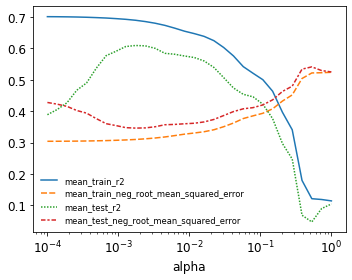

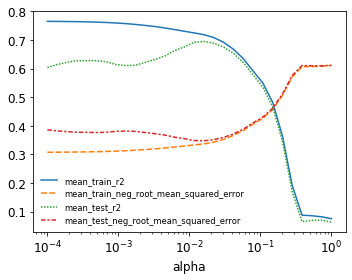

In [337]:
models = {'SiteEnergyUse_log':SEUmodel3, 'TotalGHGEmissions_log':GHGmodel3}
for target, m in models.items():
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("\nRésultat pour la cible {}:".format(target_name))

    features = pd.Index(features).drop(['LargestPropertyUseType'])
    
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = m1[features]
    y = m1[target]
    
    
    ############################### Pipeline #################################################################
    # crée les étapes de preprocessing (standardisation, , acp, one-hot encoding)
    preprocessor = preprocessing(X)
    
    # Les indices de colonnes sur lesquelles opérer la transformation vont de 0 au nombre de colonnes dans le
    # numpy.array créé après preproc2.
    cat_var = X.dtypes[X.dtypes=='category'].index
    
    # nombre total de modalités, i.e. de nouvelles colonnes créées par dummy encoding
    nb_dummycols = X[cat_var].nunique().sum()
    
    # nombre de colonnes dans X_train après preprocessor2
    nb_cols = int(len(features)-len(cat_var)+nb_dummycols-len(pca_cols)+4)
    
    poly = PolynomialFeatures(degree=2)
    preprocessor_poly = ColumnTransformer(transformers=[('polyfeat', poly, np.arange(0, nb_cols))])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('preprocessor_poly', preprocessor_poly),
                          ('regressor', Lasso(tol=1e-4, max_iter=1e5))
                         ])
    ##########################################################################################################
    
    # Valeurs possibles du paramètre alpha
    params = {"alpha" : np.logspace(-4, 0, 30)}
    
    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {}
    for key, values in params.items():
        param_grid["regressor__"+key] = values
        
        
    # Régression avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    reg,            # modèle
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,    # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
    return_train_score=True,
    refit='r2',
    )
    
    # Séparation entraînement-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train, y_train)
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)
    
    # Performance sur le jeu d'entraînement
    print("\nPerformance sur le jeu d'entraînement' : {:.3f}".format(regr.score(X_train, y_train)))
        
    # Performance en généralisation du meilleur modèle sur le set de test
    y_pred = regr.predict(X_test)
    print("Performance en généralisation sur le jeu de test : {:.3f}\n".format(r2_score(y_test, y_pred)))
    
    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, regr, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, 
                         plot_param=list(params.keys()), savefig=True, 
                         figname=f'polyfit_{target_name}')

Les scores obtenus indique une amélioration par rapport au modèle de régression linéaire. Prendre en compte les interactions a clairement permis de capter un peu plus d'information. 

On va maintenant chercher à obtenir plus d'informations sur la sélection de variables réalisée par Lasso. On va donc utiliser SelectFromModel avec comme estimateur Lasso et comme hyperparamètre la valeur de alpha déterminée précédemment, et on va afficher les features retenues ainsi que leur coefficient respectif. On pourra ainsi voir quelles sont les sources de non-linéarité les plus importantes.

Features selected by SelectFromModel: 


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


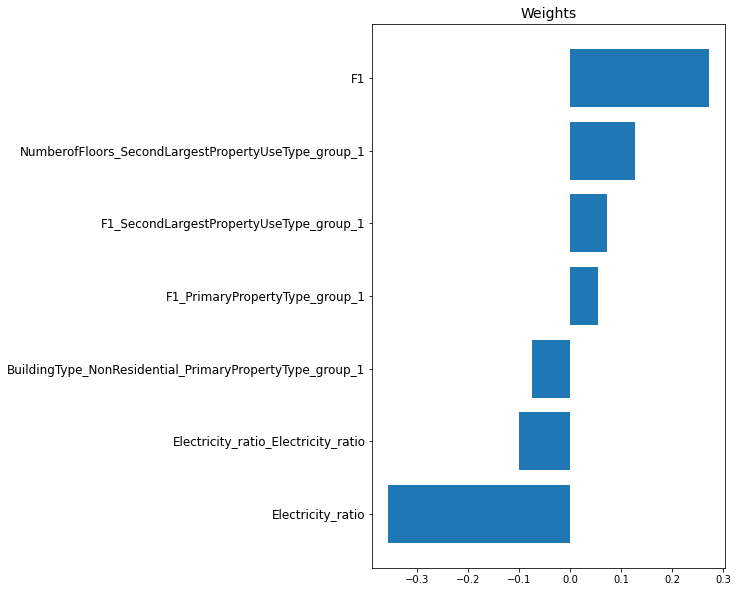

In [94]:
import itertools

# SelectFromModel, seuil à 5%
sfm = SelectFromModel(Lasso(alpha=regr.best_params_['regressor__alpha'], tol=1e-3, max_iter=1e5),
                      threshold=5e-2)

# transformation du dataset
reg1 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('preprocessor_poly', preprocessor_poly), 
                       ('sfm', sfm), 
                       ('pass', 'passthrough')])
reg1.fit(X_train, y_train)

# Affichage des variables retenues
print("Features selected by SelectFromModel: ")

########################   reconstitution de la liste de variables obtenues après preprocessing ##############
num_cols = ['NumberofBuildings', 'NumberofFloors', 'Electricity_ratio', 'F1',
            'F2', 'F3', 'F4']
dummies = []
for c in cat_var:
    for m in np.sort(X[c].unique()):
        dummies.append(c+"_{}".format(m))

# reconstitution des "features" de base, obtenues après le standardisation, pca et one-hot encoding
features = list(np.concatenate((num_cols, dummies)))

# Constitution des interactions, c'est-à-dire de toutes les combinaisons deux-à-deux des colonnes.
poly_features = [a+'_'+b for (a,b) in list(itertools.combinations_with_replacement(features, 2))]
features += poly_features

# PolynomialFeatures crée également une nouvelle variable jouant le rôle de l'"intercept". 
features.insert(0, '1')
##############################################################################################################

# Récupération des coefficients de la régression
fitted_sfm = reg1.named_steps['sfm']
est = fitted_sfm.estimator_.coef_

# récupération de la sous-sélection de variables opérée par SelectFromModel
feat_sfm=fitted_sfm.get_support()

# Affichage des résultats sous forme de diagramme en bâtons
ft = np.array(features)[feat_sfm]
f = pd.Series(data=est[feat_sfm], index=ft, name='coefficient').sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(f.index, f)
ax.invert_yaxis()
ax.set_title("Weights", size=14)
ax.set_yticklabels(f.index, size=12)
plt.subplots_adjust(left=0.5, right=0.99)
plt.savefig('./polycoefs', dpi=300)
plt.show()

Pour finir, on réalise une validation croisée avec la valeur optimale de alpha.

In [338]:
models = {'SiteEnergyUse_log':SEUmodel3, 'TotalGHGEmissions_log':GHGmodel3}

# valeurs optimales de l'hyperparamètre alpha pour chaque cible
param_poly = {'SiteEnergyUse_log':0.00174, 'TotalGHGEmissions_log':0.0161}

for k, m in models.items():
    target_name = k.split('_')[0]
    m1, features = modelpreparation(m)

    print("Résultat pour la cible {}:".format(target_name))
    
    # Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
    X = m1[features]
    y = m1[target]
    
    ## nouveau pipeline
    poly_p = Pipeline(steps=[('preprocessor', preprocessor),
                             ('preprocessor_poly', preprocessor_poly), 
                             ('regressor', Lasso(alpha=param_poly[k],
                                                 tol=1e-4,
                                                 max_iter=1e5))]) 
    scores = cross_validate(poly_p, X, y, cv=5, return_estimator=True)
    fitted_lasso = scores['estimator'][0].named_steps['regressor']
    nb_var = fitted_lasso.n_features_in_
    coefs = fitted_lasso.coef_
    nb_coefs = coefs[coefs>0].shape
    print(f"Nombre de variables avant régularisation= {nb_var}")
    print(f"Nombre de variables après régularisation: {nb_coefs}")
    print("R2 = {:.2f} +/- {:.2f}".format(scores['test_score'].mean(), scores['test_score'].std()))
    print('')

Résultat pour la cible SiteEnergyUse:
Nombre de variables avant régularisation= 171
Nombre de variables après régularisation: (31,)
R2 = 0.67 +/- 0.10

Résultat pour la cible TotalGHGEmissions:
Nombre de variables avant régularisation= 171
Nombre de variables après régularisation: (11,)
R2 = 0.66 +/- 0.06



In [339]:
scores

{'fit_time': array([0.09000707, 0.08501387, 0.08427978, 0.08464599, 0.0844419 ]),
 'score_time': array([0.01735687, 0.02515507, 0.01616526, 0.01615191, 0.016397  ]),
 'estimator': (Pipeline(steps=[('preprocessor',
                   Pipeline(steps=[('preprocessor1',
                                    ColumnTransformer(remainder='passthrough',
                                                      transformers=[('num',
                                                                     StandardScaler(),
                                                                     <sklearn.compose._column_transformer.make_column_selector object at 0x1a369bb710>),
                                                                    ('std_pca',
                                                                     Pipeline(steps=[('standardscaler',
                                                                                      StandardScaler()),
                                                 

In [313]:
poly_p.named_steps['regressor']

Lasso(alpha=0.01, max_iter=100000.0)

Ceci confirme l'amélioration obtenue par rapport à la régression linéaire simple.

## III.4 kNN

L'estimateur k-NN permet de s'affranchir de l'hypothèse de linéarité. On utilise cet estimateur pour voir si on arrive à capter plus d'information du jeu de données si on s'affranchit de cette hypothèse. On utilise les jeux de  données SEUmodel3 et GHGmodel3 car ils semblent donner de meilleurs résultats en généralisation que les jeux de données SEUmodel2 et GHGmodel2


Résultat pour la cible SiteEnergyUse:

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 5}

Performance sur le jeu d'entraînement' : 0.790
Performance en généralisation sur le jeu de test : 0.726

Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.783 +/- 0.002
RMSE: 0.257 +/- 0.003


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.675 +/- 0.020
RMSE: 0.315 +/- 0.023

Résultat pour la cible TotalGHGEmissions:

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__n_neighbors': 5}

Performance sur le jeu d'entraînement' : 0.826
Performance en généralisation sur le jeu de test : 0.764

Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.816 +/- 0.004
RMSE: 0.269 +/- 0.004


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.724 +/- 0.018
RMSE: 0.329 +/- 0.020


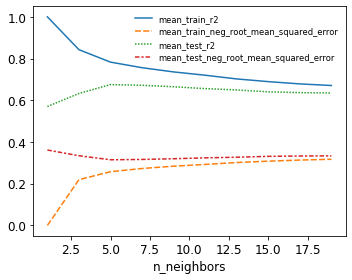

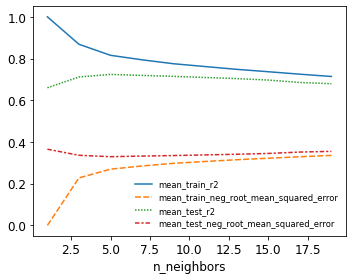

In [52]:
from sklearn.neighbors import KNeighborsRegressor
models = {'SiteEnergyUse_log':SEUmodel3, 'TotalGHGEmissions_log':GHGmodel3}
for target, m in models.items():
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("\nRésultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles du nombre de plus proches voisins
    params = {"n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
    
    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')
    
    # modèle
    model = KNeighborsRegressor()
    
    # chargement du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)
    
    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, axis_scale="linear", plot_param=list(params.keys()), savefig=True, figname=f'knn_{target_name}')

kNN permet de régler la complexité du modèle et a permis ainsi une amélioration significative des scores d'entraînement et de test, mais les scores finaux 0.68 (SEU) et 0.72 (GHG) restent modestes. On va essayer le même type d'analyse avec RandomForestRegressor et ainsi déterminer si il est possible d'avoir un meilleur compromis biais-variance, et on va essayer de diminuer la taille du modèle grâce à l'attribut "feature_importances_" permettant, en association avec SelectFromModel de sélectionner les variables pertinentes. Comme RandomForestRegressor.feature_importances_ souffre de potentiels biais (notamment envers les variables avec un grand nombre de modalités), on va également inspecter l'importance des différentes variables grâce à sklearn.inspection.permutation_importance. On en déduira deux modèles, qu'on pourra alors comparer pour sélectionner le meilleur.

## III.5 RandomForestRegressor

On reprend le jeu de données initial pour déterminer les valeurs optimales des hyperparamètres n_estimators, max_depth et max_features.

Résultat pour la cible SiteEnergyUse:

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100}

Performance sur le jeu d'entraînement' : 0.973
Performance en généralisation sur le jeu de test : 0.830

Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.970 +/- 0.001
RMSE: 0.095 +/- 0.002


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.792 +/- 0.022
RMSE: 0.252 +/- 0.024
Résultat pour la cible TotalGHGEmissions:


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "



Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__n_estimators': 500}

Performance sur le jeu d'entraînement' : 0.977
Performance en généralisation sur le jeu de test : 0.860

Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.975 +/- 0.001
RMSE: 0.098 +/- 0.003


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.816 +/- 0.028
RMSE: 0.268 +/- 0.027


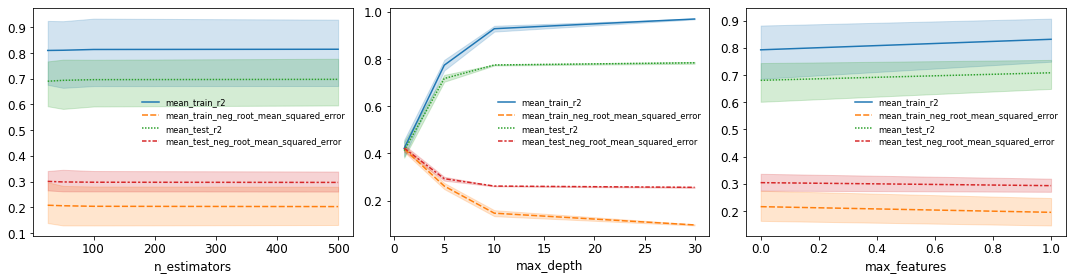

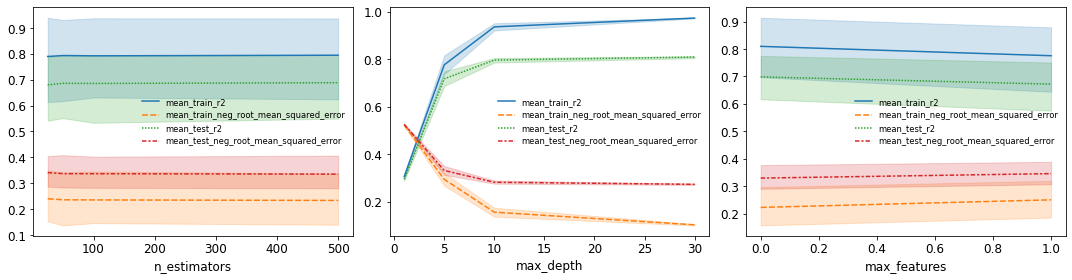

In [340]:
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}

for k, m in models.items():
    target = k
    target_name = target.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))
    
    # Valeurs possibles des hyperparamètres
    params = {"n_estimators" : [25,50,100, 500], 
              "max_depth" : [None, 1, 5, 10, 30], 
              "max_features" : ['auto', "sqrt"]}

    # Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
    score = ('r2', 'neg_root_mean_squared_error')

    # modèle
    model = RandomForestRegressor(oob_score=True)

    # Preprocessing et fit du modèle
    gspipeline = crossval_GS(target, features, m1, params, model, score)

    # DataFrame des résultats de la validation croisée
    cvresults = print_cvresults(score, gspipeline, params)
    
    # Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
    plot_traintestscores(cvresults, score, plot_param=list(params.keys()), axis_scale='linear', savefig=True, figname=f'rfr_{target_name}')

Les scores d'entraînement et de test sont en nette amélioration par rapport aux modèles précédents.

On cherche maintenant à interpréter le modèle et eventuellement à le simplifier à l'aide de deux méthodes:
* RandomForestRegressor.feature_importances_
* sklearn.inspection.permutation_importance

Résultat pour la cible SiteEnergyUse:


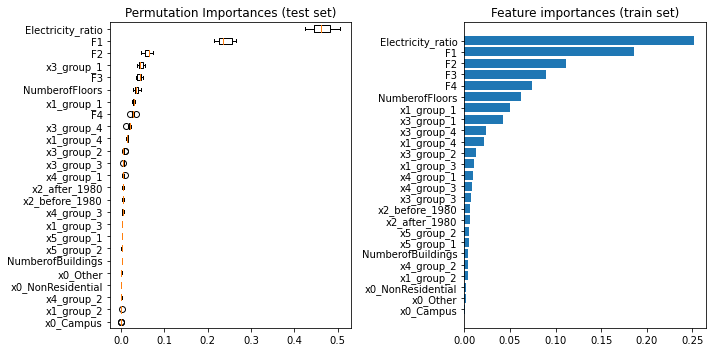

Résultat pour la cible TotalGHGEmissions:


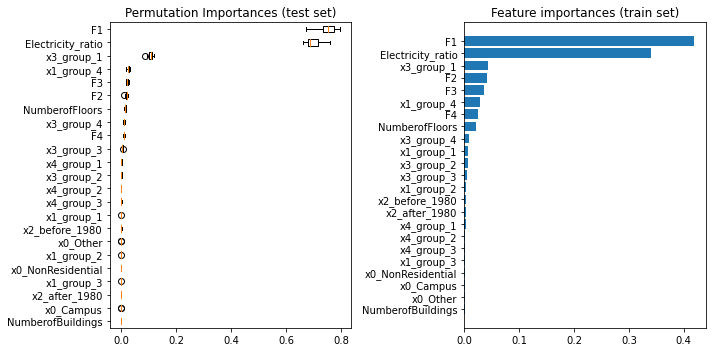

In [89]:
from sklearn.inspection import permutation_importance
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}
param_rf = {'SiteEnergyUse_log': [500, None, 'sqrt'], 'TotalGHGEmissions_log':[500, None, 'auto']}

for k, m in models.items():
    target_name = k.split('_')[0]
    m1, features = modelpreparation(m)
    print("Résultat pour la cible {}:".format(target_name))

    # Séparation prédicteurs - cible
    X = m1[features]
    y = m1[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Permutation importance
    # Pipeline de transformation du dataset uniquement
    preprocessor = preprocessing(X)
    X_train_transf = preprocessor.fit_transform(X_train)
    X_test_transf = preprocessor.transform(X_test)
    
    # Création d'un nouvel estimateur
    rfr = RandomForestRegressor(n_estimators=param_rf[k][0],
                                max_depth=param_rf[k][1],
                                max_features=param_rf[k][2])
    rfr.fit(X_train_transf, y_train)
    
    result = permutation_importance(rfr, X_test_transf, y_test, n_repeats=10, random_state=0)
    sorted_idx = result.importances_mean.argsort()
    
    # Création du pipeline constitué d'une étape de normalisation, d'ACP et de l'estimateur. 
    rfr1 = RandomForestRegressor(n_estimators=param_rf[k][0], 
                                 max_depth=param_rf[k][1], 
                                 max_features=param_rf[k][2])
    reg = create_pipeline(rfr1, X_train, regressor=True)
    
    # Fit transform
    reg.fit(X_train, y_train)
    
    # Feature importances
    feat_importances = reg.named_steps['regressor'].feature_importances_
    
    # Affichage des résultats dans un dataframe
    
    # Récupération des colonnes de type numérique (non catégoriel) du dataframe avant transformation
    num_cols = X.dtypes[X.dtypes!='category'].index
    
    # Colonnes correspondant au dataframe transformé
    preprocessor1 = preprocessor.named_steps['preprocessor1']
    onehot_cols = preprocessor1.named_transformers_['cat'].get_feature_names()
    num_nopca_cols = pd.Index([c for c in num_cols if not c in PCA_COLS])
    labels = np.concatenate((num_nopca_cols,
                             ['F1', 'F2', 'F3', 'F4'], 
                             onehot_cols,
                             ))
    labels = pd.Index(labels)    
    feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                       index=labels).sort_values(by=['feature importance'],
                                                                 ascending=False)
    
    # Affichage des features par ordre d'importance
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=labels[sorted_idx])
    ax1.set_title("Permutation Importances (test set)")
    
    f = feature_importances["feature importance"]
    ax2.barh(f.index, f)
    ax2.set_title("Feature importances (train set)")
    ax2.invert_yaxis()
    fig.tight_layout()
    plt.savefig('./feat_importancesrfr', dpi=300)
    plt.show()

Les deux méthodes donnent des résultats remarquablement similaires. De plus, cette fois-ci un grand nombre de variables sont "annulées", ce qui permet d'effectuer une sélection intéressante.
On va réutiliser RandomForestRegressor sur une sous-sélection basée sur les résultats obtenus, avec le meilleur hyperparamètre (ici on choisit 100 car on n'observe pas d'amélioration significative des performances avec un nombre d'estimateurs plus grand).

# IV Choix du modèle

On reprend tous les modèles explorés avec les hyperparamètres déterminés par validation croisée et on les fait tourner sur le jeu d'entraînement pour comparer les scores et les temps de fit/prediction. On choisira lemodèle qui représente le meilleur compromis entre ces grandeurs.

On commence par définir deux fonctions: la première réalise le benchmark, la deuxième affiche les résultats.

In [289]:
from time import time
def benchmark(reg, X_train, X_test, y_train, y_test):

    t0 = time()
    reg.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = reg.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = r2_score(y_test, pred)
    print("score:   %0.3f" % score)

    print()
    
    try:
        reg_descr = str(reg.named_steps['regressor']).split('(')[0]
    except:
        reg_descr = str(reg).split('(')[0]
    
    return reg_descr, score, train_time, test_time


def plot_comparisons(results, target):
    """Affiche un diagramme en bâtons de comparaison de différents modèles. Les grandeurs comparées sont 
    le score en généralisation, le temps d'entraînement et le temps de test.
    
    Parameters
    ----------
    results: list
            List of tuples (name, train test, score test, score) for the models under comparison
    target: str
            target to predict
    
    """
    
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]
    
    reg_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Score pour la prédiction de {target}", size=14)
    ax.barh(indices, score, .2, label="score", color='navy')
    ax.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    ax.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    ax.xaxis.set_major_locator(MultipleLocator(.2))
    ax.xaxis.set_major_formatter('{x:.1f}')
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.set_yticks(())
    ax.invert_yaxis()
    ax.legend(loc='best')
    fig.subplots_adjust(left=.25)
    fig.subplots_adjust(top=.95)
    fig.subplots_adjust(bottom=.05)
    
    for i, c in zip(indices, reg_names):
        plt.text(-.01, i, c, size=14, horizontalalignment='right')
        

Comparaisons des modèles

Comparaisons pour la prédiction de SiteEnergyUse_log
Linear Regression
train time: 0.114s
test time:  0.019s
score:   0.591

Régression polynomiale et feature selection avec Lasso
train time: 0.140s
test time:  0.018s
score:   0.741

KNearestNeighbors
train time: 0.052s
test time:  0.044s
score:   0.763

Random Forest
train time: 3.363s
test time:  0.140s
score:   0.829



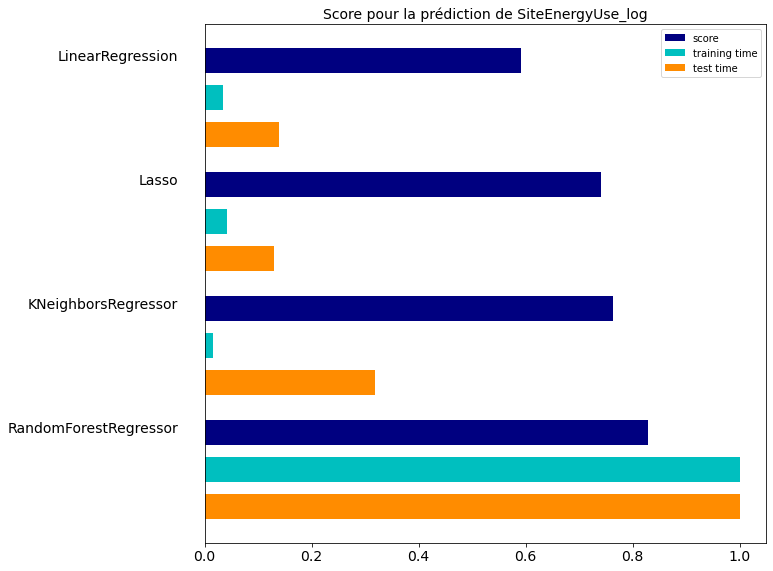

Comparaisons pour la prédiction de TotalGHGEmissions_log
Linear Regression
train time: 0.085s
test time:  0.029s
score:   0.583

Régression polynomiale et feature selection avec Lasso
train time: 0.200s
test time:  0.031s
score:   0.711

KNearestNeighbors
train time: 0.063s
test time:  0.035s
score:   0.733

Random Forest
train time: 7.331s
test time:  0.138s
score:   0.851



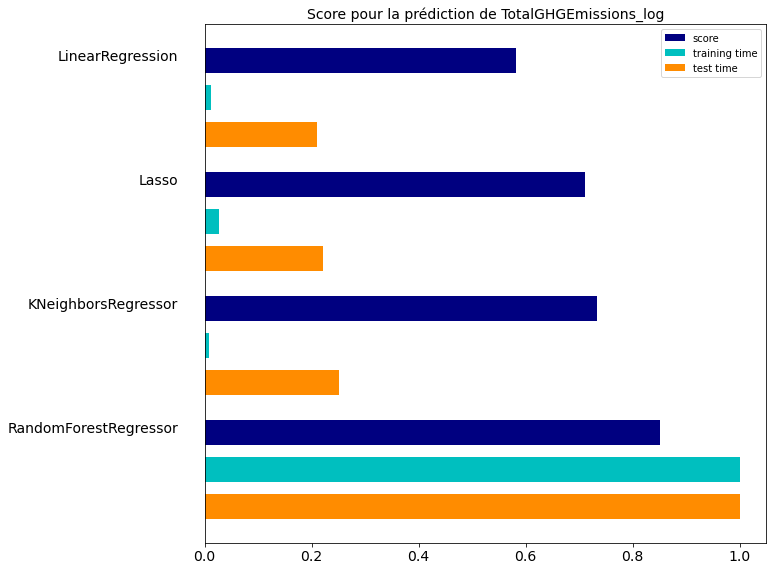

In [285]:
models = {'SiteEnergyUse_log':[SEUmodel2, SEUmodel3], 'TotalGHGEmissions_log':[GHGmodel2, GHGmodel3]}
# Hyperparamètres optimaux pour chaque modèle et cible
param_lasso = {'SiteEnergyUse_log': 1e-2, 'TotalGHGEmissions_log':1e-2}
param_knn = {'SiteEnergyUse_log': 5, 'TotalGHGEmissions_log':5}
param_rf = {'SiteEnergyUse_log': [500, None, 'sqrt'], 'TotalGHGEmissions_log':[500, None, 'auto']}

for k, m in models.items():
    print(f"Comparaisons pour la prédiction de {k}")
    m1, features = modelpreparation(m[0])
    X = m1[features]
    y = m1[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results = []
    
    # régression linéaire sur les jeux SEUmodel2 et GHGmodel2
    model = LinearRegression()
    reg = create_pipeline(model, X_train, regressor=True)
    print('=' * 80)
    print('Linear Regression')
    results.append(benchmark(reg, X_train, X_test, y_train, y_test))
                       
    # régression polynomiale sur les jeu SEUmodel3.csv et GHGmodel3.csv
    m1, features = modelpreparation(m[1])
    X = m1[features]
    y = m1[target]
    
    preprocessor = preprocessing(X)
    
    # Les indices de colonnes sur lesquelles opérer la transformation vont de 0 au nombre de colonnes dans le
    # numpy.array créé aprè preprocessor2.
    cat_var = X.dtypes[X.dtypes=='category'].index
    
    # nombre total de modalités, i.e. de nouvelles colonnes créées par dummy encoding
    nb_dummycols = X[cat_var].nunique().sum()
    
    # nombre de colonnes dans X_train après preprocessor2
    nb_cols = int(len(features)-len(cat_var)+nb_dummycols-len(pca_cols)+4)
    
    preproc3 = ColumnTransformer(transformers=[('polyfeat', poly, np.arange(0, nb_cols))])
    
    regpoly = Pipeline(steps=[('preprocessor', preprocessor),
                          ('preprocessor3', preproc3),
                          ('regressor', Lasso(tol=1e-4, max_iter=1e5, alpha=param_lasso[k]))
                         ])
    print('=' * 80)
    print('Régression polynomiale et feature selection avec Lasso')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results.append(benchmark(regpoly, X_train, X_test, y_train, y_test))
    
    
    # KNN sur les jeux SEUmodel2 et GHGmodel2
    model = KNeighborsRegressor(n_neighbors=param_knn[k])
    reg = create_pipeline(model, X_train, regressor=True)
    print('=' * 80)
    print('KNearestNeighbors')
    results.append(benchmark(reg, X_train, X_test, y_train, y_test))

    # Random Forest sur les jeux SEUmodel2 et GHGmodel2
    m1, features = modelpreparation(m[0])
    X = m1[features]
    y = m1[target]
    
    model = RandomForestRegressor(max_features=param_rf[k][2],
                                  n_estimators=param_rf[k][0])
    
    reg = create_pipeline(model, X, regressor=True)
    print('=' * 80)
    print('Random Forest')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results.append(benchmark(reg, X_train, X_test, y_train, y_test))
    
    plot_comparisons(results, k)
    plt.savefig(f"./models_comparison_{k}", dpi=300)
    plt.show()

RandomForestRegressor est le meilleur algorithme, malgré un temps d'entraînement/test beaucoup plus élevé que pour les autres modèles. En effet, on ne cherche ici qu'à optimiser la performance en généralisation. On décide de choisir ce modèle pour réaliser les prédictions de SiteEnergyUse, puis TotalGHGEmissions.

# V Améliorations du modèle final

## V.1 Sélection des features

Comparaisons pour la prédiction de SiteEnergyUse_log
Random Forest
train time: 3.584s
test time:  0.276s
score:   0.835

Random Forest with feature selection
train time: 2.572s
test time:  0.134s
score:   0.821



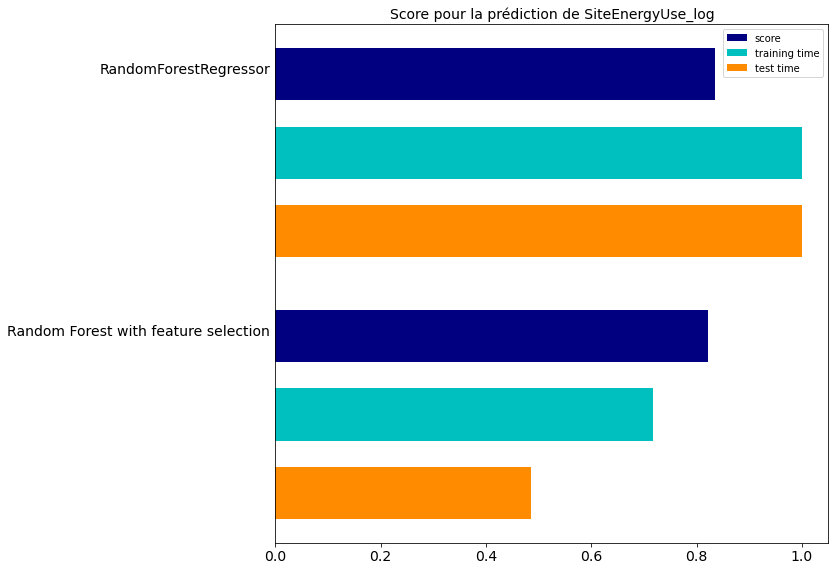

Comparaisons pour la prédiction de TotalGHGEmissions_log
Random Forest
train time: 7.354s
test time:  0.174s
score:   0.860

Random Forest with feature selection
train time: 5.088s
test time:  0.125s
score:   0.839



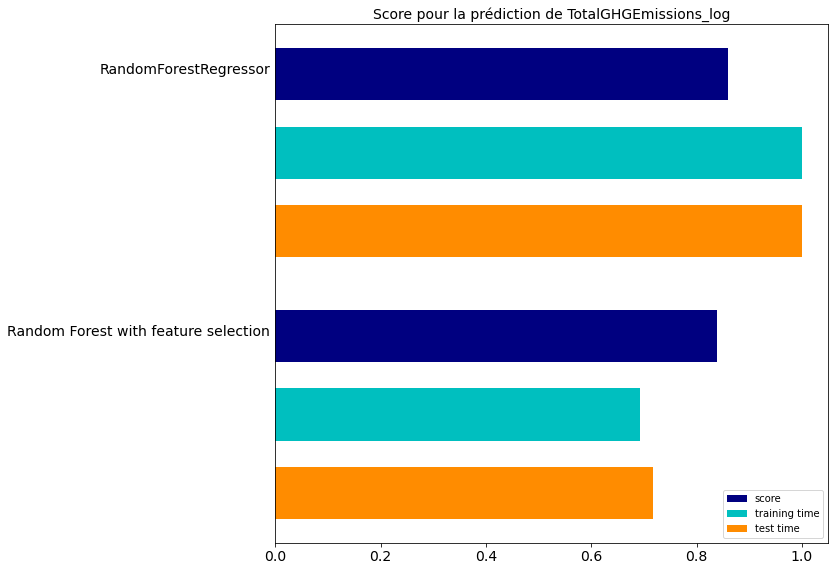

In [292]:
models = {'SiteEnergyUse_log':[SEUmodel2], 'TotalGHGEmissions_log':[GHGmodel2]}
param_rf = {'SiteEnergyUse_log': [500, None, 'sqrt'], 'TotalGHGEmissions_log':[500, None, 'auto']}

for k, m in models.items():
    print(f"Comparaisons pour la prédiction de {k}")
    target_name = k.split('_')[0]
    m1, features = modelpreparation(m[0])

    X = m1[features]
    y = m1[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results = []
    for regr, name in [(RandomForestRegressor(max_features=param_rf[k][2],
                                              n_estimators=param_rf[k][0]),"Random Forest")]:
        
        reg = create_pipeline(regr, X_train, regressor=True)
        print('=' * 80)
        print(name)
        results.append(benchmark(reg, X_train, X_test, y_train, y_test))
    
    # Entraîne RandomForest sur les features sélectionnées par feature_selection
    rfr = RandomForestRegressor(max_features=param_rf[k][2],
                                n_estimators=param_rf[k][0], 
                                max_depth=param_rf[k][1]
                               )
    rfr2 = RandomForestRegressor(max_features=param_rf[k][2],
                                n_estimators=param_rf[k][0], 
                                max_depth=param_rf[k][1])
    transf_pipe = create_pipeline(_, X_train)
    X_train_transf = transf_pipe.fit_transform(X_train)
    X_test_transf = transf_pipe.transform(X_test)

    select = SelectFromModel(estimator=rfr, threshold=0.025).fit(X_train_transf, y_train)
    X_train_sel = select.transform(X_train_transf)
    X_test_sel = select.transform(X_test_transf)
    print('=' * 80)
    print('Random Forest with feature selection')
    desc, score, train_time, test_time = benchmark(rfr2, X_train_sel, X_test_sel, y_train, y_test)
    desc = 'Random Forest with feature selection'
    results.append((desc, score, train_time, test_time))
    
    plot_comparisons(results, k)
    plt.subplots_adjust(left=0.35, right=0.99)
    plt.savefig(f"./RF_comparison_{k}", dpi=300)
    plt.show()

Variables sélectionnées:


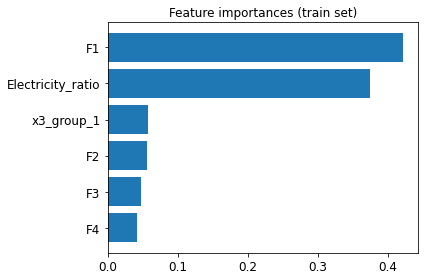

In [296]:
# Implémentation de RandomForestRegressor sur les features sélectionnées uniquement
dataset = {'TotalGHGEmissions_log':GHGmodel2}
param_rf = {'TotalGHGEmissions_log':[500, None, 'auto']}

for name, data in dataset.items():
    target_name = name.split('_')[0]
    m1, features = modelpreparation(data)
    
    X = m1[features]
    y = m1[target]
############################# Pipeline #################################################################
    preprocessor = preprocessing(X)
    
    model1 = RandomForestRegressor(max_features=param_rf[name][2],
                                    n_estimators=param_rf[name][0], 
                                    max_depth=param_rf[name][1])
    
    model2 = RandomForestRegressor(max_features=param_rf[name][2],
                                    n_estimators=param_rf[name][0], 
                                    max_depth=param_rf[name][1])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('select_features', SelectFromModel(model1, threshold=0.025)),
                          ('regressor', model2)
                         ])
    ########################################################################################################

    reg.fit(X_train, y_train)
    
    # Feature importances
    feat_importances = reg.named_steps['regressor'].feature_importances_

    
    # Récupération des colonnes de type numérique (non catégoriel) du dataframe avant transformation
    base_cols = X.dtypes[X.dtypes!='category'].index
    
    # Colonnes correspondant au dataframe transformé
    preprocessor1 = transf_pipeline.named_steps['preprocessor'].named_steps['preprocessor1']
    onehot_cols = preprocessor1.named_transformers_['cat'].get_feature_names()
    updated_cols = pd.Index([c for c in base_cols if not c in PCA_COLS])
    labels = np.concatenate((updated_cols,
                             ['F1', 'F2', 'F3', 'F4'], 
                             onehot_cols,
                             ))
    labels = pd.Index(labels)
    
    print("Variables sélectionnées:")
    feature_importances = pd.DataFrame(data={"feature importance":np.abs(feat_importances)},
                                       index=labels[reg.named_steps['select_features']
                                                    .get_support()]).sort_values(by='feature importance',
                                                                                ascending=False)
    fig, ax = plt.subplots()
    f = feature_importances["feature importance"]
    ax.barh(f.index, f)
    ax.set_title("Feature importances (train set)")
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    plt.savefig('./feat_importancesrfr_selected', dpi=300)
    plt.show()
    
    #print(feature_importances.sort_values(by='feature importance', ascending=False))

In [297]:
feature_importances

,feature importance
F1,0.421552
Electricity_ratio,0.374238
x3_group_1,0.057161
F2,0.056705
F3,0.047980
F4,0.042364


## VI.2 Prise en compte d'ENERGYSTARScore

Dans le but d'améliorer les performances du modèle, on cherche à évaluer l'importance de ENERGYSTARScore pour la prédiction. Comme vu lors de l'analyse exploratoire, ENERGYSTARScore est corrélée (faiblement) aux valeurs moyennes de SourceEUIWN, GHGEmissionsIntensity, et ces dernières sont corrélées à TotalGHGEmissions via PropertyGFABuilding(s). On souhaite maintenant quantifier cette corrélation.

TotalGHGEmissions (log) vs ENERGYSTARScore:
R2 sur le jeu de données: 0.020


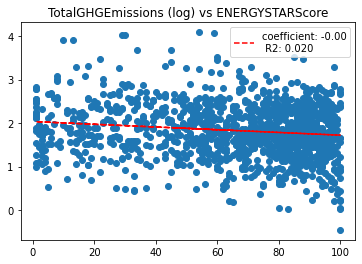

TotalGHGEmissions moyen vs ENERGYSTARScore:
R2 sur le jeu de données: 0.128


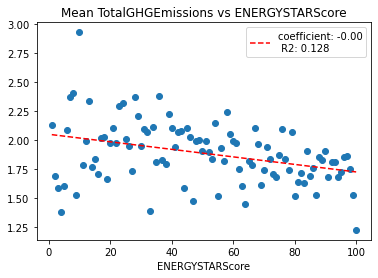

In [30]:
# prédicteurs
escmodel = GHGmodel.copy()
escmodel.dropna(subset=["ENERGYSTARScore"], inplace=True)

features = "ENERGYSTARScore"
target = "TotalGHGEmissions_log"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

# Régression linéaire sur les données brutes
lr = LinearRegression()
lr.fit(X, y)
score = lr.score(X,y)
print("TotalGHGEmissions (log) vs ENERGYSTARScore:")
print("R2 sur le jeu de données: {:.3f}".format(lr.score(X,y)))
coef = lr.coef_
intercept = lr.intercept_

fig, ax = plt.subplots()
ax.scatter(x=escmodel["ENERGYSTARScore"], y=escmodel["TotalGHGEmissions_log"])
ax.plot(escmodel["ENERGYSTARScore"], intercept + escmodel["ENERGYSTARScore"]*coef, 'r--', 
        label="coefficient: {:.2f}\n R2: {:.3f}".format(coef[0], score))
ax.set_title("TotalGHGEmissions (log) vs ENERGYSTARScore")
ax.legend()
plt.savefig('./GHGvsESC', dpi=300)
plt.show()

# Régression linéaire sur les valeurs moyennes de TotalGHGEmissions pour chaque valeur de ENERGYSTARScore
features = "ENERGYSTARScore"
target = "TotalGHGEmissions_log"

X = escmodel[features].values.reshape(-1, 1)
y = escmodel[target].values

X= escmodel.groupby(features).mean()[target].index.to_numpy().reshape(-1, 1)
y = escmodel.groupby(features).mean()[target].values

lr.fit(X, y)
print("="*80)
print("TotalGHGEmissions moyen vs ENERGYSTARScore:")
score = lr.score(X,y)
print("R2 sur le jeu de données: {:.3f}".format(score))
coef = lr.coef_
intercept = lr.intercept_

indices = escmodel.groupby(features).mean()[target].index.values
fig, ax = plt.subplots()
ax.scatter(escmodel.groupby(features).mean()[target].index.to_numpy(),  y)
ax.plot(indices, intercept + indices*coef, 'r--', label="coefficient: {:.2f}\n R2: {:.3f}".format(coef[0], score))
ax.set_title("Mean TotalGHGEmissions vs ENERGYSTARScore")
ax.set_xlabel("ENERGYSTARScore")
ax.legend()
plt.savefig('./meanGHGvsESC', dpi=300)
plt.show()

Le coefficient de corrélation linéaire indique une corrélation (très) faible avec TotalGHGEmissions, mais l'effet est clair lorsqu'on étudie la corrélation des  _valeurs moyennes_ de TotalGHGEmissions avec ENERGYSTARScore. Ceci suggère qu'ajouter ENERGYSTARScore aux prédicteurs pourrait permettre d'améliorer les prédictions. Dans la suite, on cherche donc à évaluer explicitement les améliorations apportées au modèle via la prise en compte d'ENERGYSTARScore. Comme il y a un certain nombre de lignes pour lesquelles ENERGYSTARScore n'est pas renseigné, le jeu de données est donc restreint à 1307 individus. On évalue également les différences de performances en généralisation obtenues __sans ENERGYSTARScore__ entre ce jeu de données restreint et le jeu de données initial comportant 1846 individus.

In [246]:
dataset = {'TotalGHGEmissions_log':GHGmodel2}
param_rf = {'TotalGHGEmissions_log':[500, None, 'auto']}

for name, data in dataset.items():
    target_name = name.split('_')[0]
    m1, features = modelpreparation(data)
    
    features += ['ENERGYSTARScore']
    
    # On retire les lignes pour lesquelles ENERGYSTARScore n'est pas renseignée
    m1.dropna(subset=['ENERGYSTARScore'], inplace=True)

    
    X = m1[features]
    y = m1[target]
    
    
    ############################# Pipeline #################################################################
    preprocessor = preprocessing(X)
    
    model1 = RandomForestRegressor(max_features=param_rf[name][2],
                                    n_estimators=param_rf[name][0], 
                                    max_depth=param_rf[name][1])
    
    model2 = RandomForestRegressor(max_features=param_rf[name][2],
                                    n_estimators=param_rf[name][0], 
                                    max_depth=param_rf[name][1])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('select_features', SelectFromModel(model1, threshold=0.02)),
                          ('regressor', model2)
                         ])
    ########################################################################################################
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    cv = cross_validate(reg, X, y, cv=kf, scoring=('r2'))
    
    # Résultats
    cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
    print("\nRésultat pour la cible {}, avec ENERGYSTARScore:".format(target_name))
    print("\nR2 sur le jeu de test (validation croisée): {:.2f} +/- {:.2f}".format(
        cv_results["test_score"].mean(),
        cv_results["test_score"].std()))
    
    print("="*80)


Résultat pour la cible TotalGHGEmissions:

R2 sur le jeu de test (validation croisée): 0.92 +/- 0.01


In [247]:
# Sans ENERGYSTARScore cette fois
features.remove('ENERGYSTARScore')

X = m1[features]
y = m1[target]


############################# Pipeline #################################################################
preprocessor = preprocessing(X)

model1 = RandomForestRegressor(max_features=param_rf[name][2],
                                n_estimators=param_rf[name][0], 
                                max_depth=param_rf[name][1])

model2 = RandomForestRegressor(max_features=param_rf[name][2],
                                n_estimators=param_rf[name][0], 
                                max_depth=param_rf[name][1])

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('select_features', SelectFromModel(model1, threshold=0.02)),
                      ('regressor', model2)
                     ])
########################################################################################################

# cross-validation
kf = KFold(n_splits=5, shuffle=True)
cv = cross_validate(reg, X, y, cv=kf, scoring=('r2'))

# Résultats
cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
print("\nRésultat pour la cible {} sur le jeu de données restreint, sans ENERGYSTARScore:".format(target_name))
print("\nR2 sur le jeu de test (validation croisée): {:.2f} +/- {:.2f}".format(
    cv_results["test_score"].mean(),
    cv_results["test_score"].std()))

print("="*80)


Résultat pour la cible TotalGHGEmissions:

R2 sur le jeu de test (validation croisée): 0.88 +/- 0.02


In [277]:
dataset = ('TotalGHGEmissions_log', GHGmodel2)
param_rf = {'TotalGHGEmissions_log':[500, None, 'auto']}

name, data = dataset[0], dataset[1]
target_name = name.split('_')[0]
m1, features = modelpreparation(data)

X = m1[features]
y = m1[target]


############################# Pipeline #################################################################
preprocessor = preprocessing(X)

model1 = RandomForestRegressor(max_features=param_rf[name][2],
                                n_estimators=param_rf[name][0], 
                                max_depth=param_rf[name][1])

model2 = RandomForestRegressor(max_features=param_rf[name][2],
                                n_estimators=param_rf[name][0], 
                                max_depth=param_rf[name][1])

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('select_features', SelectFromModel(model1, threshold=0.02)),
                      ('regressor', model2)
                     ])
########################################################################################################

# cross-validation
kf = KFold(n_splits=5, shuffle=True)
cv = cross_validate(reg, X, y, cv=kf, scoring=('r2'))

# Résultats
cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
print("\nRésultat pour la cible {}, sur le jeu de données initial, sans ENERGYSTARScore:".format(target_name))
print("\nR2 sur le jeu de test (validation croisée): {:.2f} +/- {:.2f}".format(
    cv_results["test_score"].mean(),
    cv_results["test_score"].std()))

print("="*80)


Résultat pour la cible TotalGHGEmissions:

R2 sur le jeu de test (validation croisée): 0.84 +/- 0.02


Comme attendu, il semble que prendre en compte ENERGYSTARScore apporte une amélioration du score de la prédiction des GES. De plus, travailler sur le jeu de données restreint (uniquement les individus pour lesquels ENERGYSTARScore est renseigné) semble apporter une augmentation des performances de généralisation, __même lorsqu'on ne prend pas en compte ENERGYSTARScore.__ On va donc, dans une démarche d'amélioration du modèle, comparer deux modèles: le jeu de données restreint, avec la feature ENERGYSTARScore, et le jeu de données initial, sans ENERGYSTARScore.

## V.3 Modèle séquentiel vs modèle non séquentiel

On étudie dans cette dernière partie deux modèles différents pour prédire la consommation totale d'énergie et les émissions de GES:
- un premier modèle dit séquentiel où on va chercher à prédire d'abord SiteEnergyUse, puis dans un second temps TotalGHGEmissions à partir des prédictions de SiteEnergyUse 
- un deuxième modèle dit non-séquentiel où on va chercher à prédire SiteEnergyUse et TotalGHGEmissions indépendamment l'une de l'autre.

### V.3.1 Modèle séquentiel

On commence par évaluer par GridSearch les meilleurs hyperparamètres dans le cas d'une prédiction de TotalGHGEmissions à partir de SiteEnergyUse


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'regressor__max_depth': 30, 'regressor__max_features': 'auto', 'regressor__n_estimators': 500}

Performance sur le jeu d'entraînement' : 0.999
Performance en généralisation sur le jeu de test : 0.988

Scores moyens sur le jeu d'entraînement, avec le meilleur modèle:
R2: 0.999 +/- 0.000
RMSE: 0.023 +/- 0.001


Scores moyens sur le jeu de validation, avec le meilleur modèle:
R2: 0.990 +/- 0.004
RMSE: 0.059 +/- 0.012


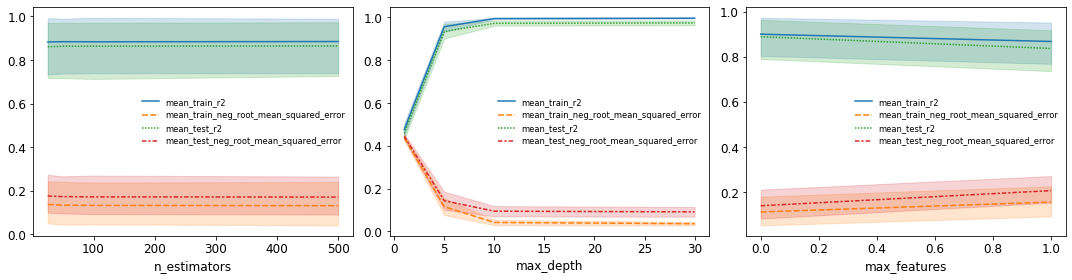

In [156]:
m1, features = modelpreparation(GHGmodel2)

features = ["ENERGYSTARScore","SiteEnergyUse_log", "Electricity_ratio", "NumberofFloors", 
            "PrimaryPropertyType", "LargestPropertyUseType"] + PCA_COLS

m1.dropna(subset=['ENERGYSTARScore'], inplace=True)

# Choisir un score à optimiser et/ou une erreur à minimiser, ici le R2 et le RMSE 
score = ('r2', 'neg_root_mean_squared_error')

# hyperparamètre
params = {"n_estimators" : [25,50,100, 500], 
              "max_depth" : [None, 1, 5, 10, 30], 
              "max_features" : ['auto', "sqrt"]}
# modèle
model = RandomForestRegressor()

# Preprocessing et fit du modèle
gspipeline = crossval_GS("TotalGHGEmissions_log", features, m1, params, model, score)

# DataFrame des résultats de la validation croisée
cvresults = print_cvresults(score, gspipeline, params)

# Graphe des résultats sur les sets d'entrainement et de test, en fonction de(s) l'hyperparamètre(s) 
plot_traintestscores(cvresults, score, plot_param=list(params.keys()), axis_scale='linear')

A condition d'utiliser SiteEnergyUse (après application du log et de StandardScaler), on obtient des résultats très satisfaisants pour TotalGHGEmissions. On va donc explorer un modèle qui combinera la prédiction sur SiteEnergyUse dans un premier temps, et se servira de cette prédiction pour prédire TotalGHGEmissions. On va également évaluer l'intérêt de prendre en compte ENERGYSTARScore pour les prédictions en estimant les score de prédiction avec et sans cette variable.

#### 1. Sans ENERGYSTARScore

In [278]:
m1, features = modelpreparation(SEUmodel2)

features = ["Electricity_ratio", "NumberofFloors", 
            "PrimaryPropertyType", "LargestPropertyUseType"] + PCA_COLS

X = m1[features]
y = m1[["SiteEnergyUse_log", "TotalGHGEmissions_log"]]

rfr = RandomForestRegressor(n_estimators=500, max_depth=None, max_features='sqrt')
SEUpipeline = create_pipeline(rfr, X, regressor=True)
scores = cross_val_score(SEUpipeline, X, y["SiteEnergyUse_log"])
print("Résultats de validation croisée pour SiteEnergyUse_log:")
print("R2 = {:.2f} +/- {:.2f}".format(scores.mean(),scores.std()))
      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # split à 50% et non l'habituel 80-20     
SEUpipeline.fit(X_train, y_train["SiteEnergyUse_log"])
seu_predictions = SEUpipeline.predict(X_test)
seu_score = r2_score(y_test["SiteEnergyUse_log"], seu_predictions)

XX = X_test.copy()
XX.loc[:, "SEU_log_pred"] = seu_predictions

rfr1 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='auto')
GHGpipeline = create_pipeline(rfr1, XX, regressor=True)
scores = cross_val_score(GHGpipeline, XX, y_test["TotalGHGEmissions_log"], cv=3)
print("\nRésultats de validation croisée pour TotalGHGEmissions_log:")
print("R2 = {:.2f} +/- {:.2f}".format(scores.mean(),scores.std()))

Résultats de validation croisée pour SiteEnergyUse_log:
R2 = 0.82 +/- 0.09

Résultats de validation croisée pour TotalGHGEmissions_log:
R2 = 0.82 +/- 0.01


#### 2. Avec ENERGYSTARScore

In [279]:
m1, features = modelpreparation(SEUmodel2)

features = ["ENERGYSTARScore", "Electricity_ratio", "NumberofFloors", 
            "PrimaryPropertyType", "LargestPropertyUseType"] + PCA_COLS

m1.dropna(subset=['ENERGYSTARScore'], inplace=True)

X = m1[features]
y = m1[["SiteEnergyUse_log", "TotalGHGEmissions_log"]]

rfr = RandomForestRegressor(n_estimators=500, max_depth=None, max_features='sqrt')


SEUpipeline = create_pipeline(rfr, X, regressor=True)


scores = cross_val_score(SEUpipeline, X, y["SiteEnergyUse_log"])
print("Résultats de validation croisée pour SiteEnergyUse_log:")
print("R2 = {:.2f} +/- {:.2f}".format(scores.mean(),scores.std()))
      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # split à 50% et non l'habituel 80-20     
SEUpipeline.fit(X_train, y_train["SiteEnergyUse_log"])
seu_predictions = SEUpipeline.predict(X_test)
seu_score = r2_score(y_test["SiteEnergyUse_log"], seu_predictions)

XX = X_test.copy()
XX.loc[:, "SEU_log_pred"] = seu_predictions

rfr1 = RandomForestRegressor(n_estimators=500, max_depth=30, max_features='auto')
GHGpipeline = create_pipeline(rfr1, XX, regressor=True)
scores = cross_val_score(GHGpipeline, XX, y_test["TotalGHGEmissions_log"], cv=3)
print("\nRésultats de validation croisée pour TotalGHGEmissions_log:")
print("R2 = {:.2f} +/- {:.2f}".format(scores.mean(),scores.std()))

Résultats de validation croisée pour SiteEnergyUse_log:
R2 = 0.90 +/- 0.04

Résultats de validation croisée pour TotalGHGEmissions_log:
R2 = 0.92 +/- 0.01


### V.3.2 Modèle non séquentiel

#### 1. Sans ENERGYSTARScore

In [243]:
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}
param_rf = {'SiteEnergyUse_log': [500, None, 'sqrt'], 'TotalGHGEmissions_log':[500, None, 'auto']}

for t, m in models.items():
    target_name = t.split('_')[0]
    m1, features = modelpreparation(m)
    
    X = m1[features]
    y = m1[target]
    
    
    ############################# Pipeline #################################################################
    preprocessor = preprocessing(X)
    
    model1 = RandomForestRegressor(max_features=param_rf[t][2],
                                    n_estimators=param_rf[t][0], 
                                    max_depth=param_rf[t][1])
    
    model2 = RandomForestRegressor(max_features=param_rf[t][2],
                                    n_estimators=param_rf[t][0], 
                                    max_depth=param_rf[t][1])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('select_features', SelectFromModel(model1, threshold=0.02)),
                          ('regressor', model2)
                         ])
    ########################################################################################################
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    cv = cross_validate(reg, X, y, cv=kf, scoring=('r2'))
    
    # Résultats
    cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
    print("\nRésultat pour la cible {}:".format(target_name))
    print("\nR2 sur le jeu de test (validation croisée): {:.2f} +/- {:.2f}".format(
        cv_results["test_score"].mean(),
        cv_results["test_score"].std()))
    
    print("="*80)


Résultat pour la cible SiteEnergyUse:

R2 sur le jeu de test (validation croisée): 0.84 +/- 0.02

Résultat pour la cible TotalGHGEmissions:

R2 sur le jeu de test (validation croisée): 0.85 +/- 0.03


#### 2. Avec ENERGYSTARScore

In [245]:
models = {'SiteEnergyUse_log':SEUmodel2, 'TotalGHGEmissions_log':GHGmodel2}
param_rf = {'SiteEnergyUse_log': [500, None, 'sqrt'], 'TotalGHGEmissions_log':[500, None, 'auto']}

for t, m in models.items():
    target_name = t.split('_')[0]
    m1, features = modelpreparation(m)
    
    m1.dropna(subset=['ENERGYSTARScore'], inplace=True)
    features += ['ENERGYSTARScore']
    
    X = m1[features]
    y = m1[target]
    
    
    ############################# Pipeline #################################################################
    preprocessor = preprocessing(X)
    
    model1 = RandomForestRegressor(max_features=param_rf[t][2],
                                    n_estimators=param_rf[t][0], 
                                    max_depth=param_rf[t][1])
    
    model2 = RandomForestRegressor(max_features=param_rf[t][2],
                                    n_estimators=param_rf[t][0], 
                                    max_depth=param_rf[t][1])
    
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('select_features', SelectFromModel(model1, threshold=0.02)),
                          ('regressor', model2)
                         ])
    ########################################################################################################
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    cv = cross_validate(reg, X, y, cv=kf, scoring=('r2'))
    
    # Résultats
    cv_results = pd.DataFrame(cv).sort_values(by="test_score", ascending=False)
    print("\nRésultat pour la cible {}:".format(target_name))
    print("\nR2 sur le jeu de test (validation croisée): {:.2f} +/- {:.2f}".format(
        cv_results["test_score"].mean(),
        cv_results["test_score"].std()))
    
    print("="*80)


Résultat pour la cible SiteEnergyUse:

R2 sur le jeu de test (validation croisée): 0.91 +/- 0.01

Résultat pour la cible TotalGHGEmissions:

R2 sur le jeu de test (validation croisée): 0.91 +/- 0.03


# Résumé

On affiche ci-dessous la table résumant les résultats obtenus. On note:
* dataset1: le jeu de données complet, après sélection des features
* dataset2: le jeu de données (après sélection des features) restreint aux individus pour lesquels ENERGYSTARScore est renseigné, et incluant la variable ENERGYSTARScore


||SiteEnergyUse_log|TotalGHGEmissions_log
|----|----|----
modèle séquentiel, dataset1 | R2 = 0.82 +/- 0.09 | R2 = 0.82 +/- 0.02
**modèle séquentiel, dataset2** | **R2 = 0.90 +/- 0.04** | **R2 = 0.92 +/- 0.01**
|||
modèle non-séquentiel, dataset1 | R2 = 0.84 +/- 0.03 | R2 = 0.85 +/- 0.02
**modèle non-séquentiel, dataset2** | **R2 = 0.91 +/- 0.01** | **R2 = 0.91 +/- 0.03**

Il semble donc que:
1. Prendre en compte ENERGYSTARScore permet d'améliorer les prédictions, à la fois par la mise à l'écart d'éléments introduisant du bruit dans le modèle et la prise en compte d'une variable corrélée avec la cible
2. Les résultats sur chaque modèle sont équivalents